In [1]:
import os
import numpy as np
import imageio
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle as pkl


BASELINE = 12 # cm
PIXEL_LENGTH = 0.0002 # cm
FOCAL_LENGTH = PIXEL_LENGTH*1000 # cm (may need to double check camera model)

l_img_dir = './dataset/testing/left_camera/'
r_img_dir = './dataset/testing/right_camera/'
disp_dir = './results/'
l_data_path = '../camera-main/videos/1636318488/1636318488-leftDLC_resnet50_make_tea_multiNov11shuffle1_50000_full.pickle'


def pixelTo3DCameraCoord(left_img, disp_map, coords):
    result_coords = []
    img_dims, disp_dims = left_img.shape, disp_map.shape
    fixed_ratios = [img_dims[dim]/disp_dims[dim] for dim in range(2)]
    for pix in coords:
        # Different ordering of dims between coordinate and images fixed here.
        x_l, y_l = (int(i) for dim, i in enumerate(pix[0]))
        d_x, d_y = int(pix[0][0]/fixed_ratios[1]), int(pix[0][1]/fixed_ratios[0])
        d = im_disp[d_y, d_x]*fixed_ratios[1]
        x_r = int(x_l - d)
        
        # Z is the depth from camera center in cm and X, Y for the other 2 axis.
        Z = BASELINE*FOCAL_LENGTH/(d*PIXEL_LENGTH)
        X, Y = (x_l - img_dims[1]/2)*PIXEL_LENGTH*Z/FOCAL_LENGTH, (y_l - img_dims[0]/2)*PIXEL_LENGTH*Z/FOCAL_LENGTH
        result_coords.append({'left_x':x_l, 'left_y':y_l, 'right_x':x_r, 'X':X, 'Y':Y, 'Z':Z})
    return result_coords

# Getting the coordinate from the dlc folder for now
l_dataf = open(l_data_path, 'rb')
l_data = pkl.load(l_dataf)
l_dataf.close()

left_cam_files = os.listdir(l_img_dir)
disp_files = os.listdir(disp_dir)
cam_coordinates = {}
for framename in l_data.keys():
    img_file = '{}.png'.format(framename)
    disp_file = "{}_disp.npy".format(img_file.split('.')[0])
    if img_file in left_cam_files and disp_file in disp_files:
        im_disp = np.load(disp_dir + disp_file)
        im_l = imageio.imread(l_img_dir + img_file)
        coordinates = l_data[framename]['coordinates'][0]
        cam_coordinates[img_file] = pixelTo3DCameraCoord(im_l, im_disp, coordinates)
        

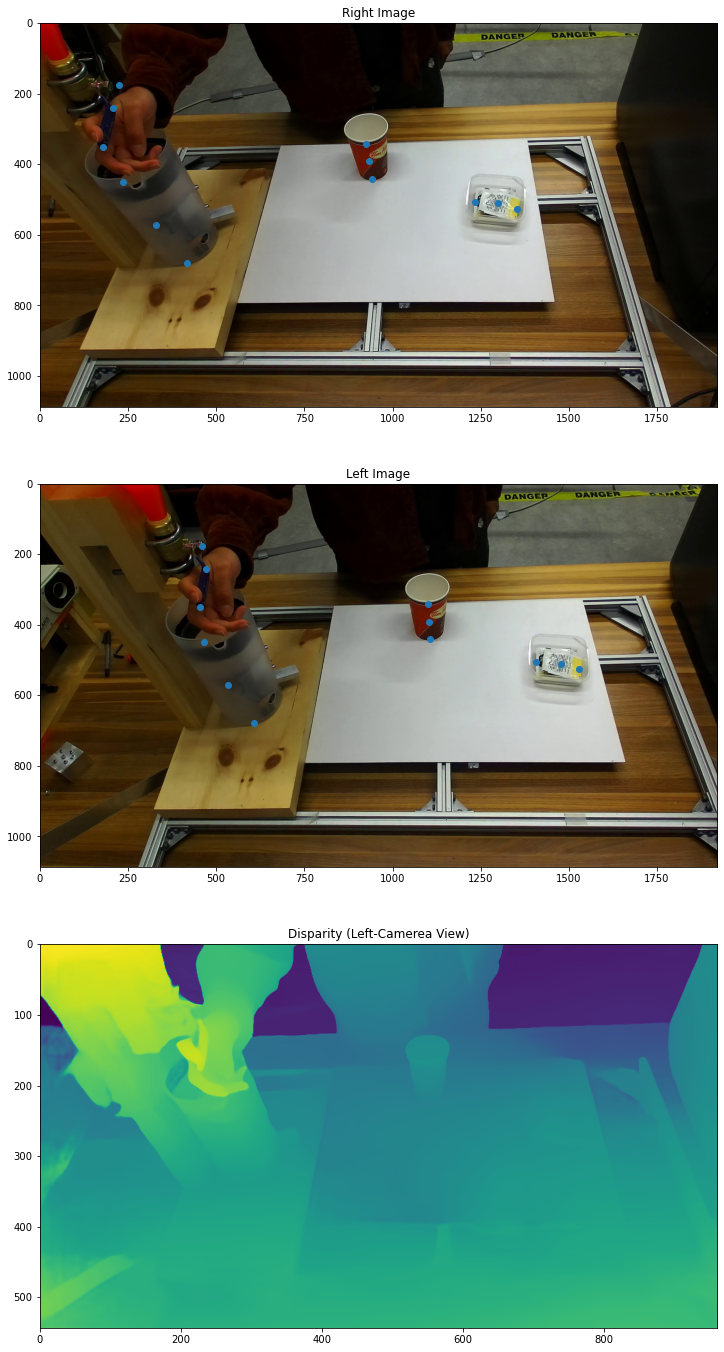

In [19]:
# Select the frame in the dataset folder that will be shown below
shown_frame = 'frame204.png'

lx, ly, rx = [], [], []
for coor in cam_coordinates[shown_frame]:
    lx.append(coor['left_x'])
    ly.append(coor['left_y'])
    rx.append(coor['right_x'])
img_left = imageio.imread(l_img_dir + shown_frame)
img_right = imageio.imread(r_img_dir + shown_frame)
disp_path = "{}_disp.npy".format(disp_dir + shown_frame.split('.')[0])
img_disparity = np.load(disp_path)
fig = plt.figure(figsize=(16, 24))
fig.add_subplot(3, 1, 1)
plt.title('Right Image')
plt.imshow(img_right)
plt.scatter(rx, ly)
fig.add_subplot(3, 1, 2)
plt.title('Left Image')
plt.imshow(img_left)
plt.scatter(lx, ly)
fig.add_subplot(3, 1, 3)
plt.title('Disparity (Left-Camerea View)')
plt.imshow(img_disparity)

In [ ]:
%matplotlib widget

x, y, z = [], [], []
for pix in cam_coordinates[shown_frame]:
    x.append(pix['X'])
    y.append(pix['Y'])
    z.append(pix['Z'])
    
fig = plt.figure()
ax = Axes3D(fig)

# Z-axis increasing the further objects are and X-axis increasing to the right 
# is the original camera view in the left camera coordinate system.
plot_geeks = ax.scatter(x, y, z)
ax.set_title('3D Coordinate Plot')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()